In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.models import Sequential,load_model
from keras import layers,Input
from keras.losses import binary_crossentropy
from keras.layers import Dense
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
import keras.backend as K

2023-12-18 15:09:23.576035: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-18 15:09:25.695224: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
state0_1,state1_1=np.load('../Data/ML/121623/state0_1.npy'),np.load('../Data/ML/121623/state1_1.npy')
state0_2,state1_2=np.load('../Data/ML/121623/state0_2.npy'),np.load('../Data/ML/121623/state1_2.npy')
state0_3,state1_3=np.load('../Data/ML/121623/state0_3.npy'),np.load('../Data/ML/121623/state1_3.npy')
output0=np.zeros((state0_1.shape[0]))
output1=np.ones((state1_1.shape[0]))
print(output0.shape,output1.shape)

(19150,) (19395,)


In [3]:
x=np.stack((np.vstack((state0_1,state1_1)),np.vstack((state0_2,state1_2)),np.vstack((state0_3,state1_3))),axis=2)
print(x.shape)
y=np.hstack((output0,output1))
print(y.shape)

(38545, 2, 3)
(38545,)


[1.13417899]
[0.56707478]
[0.56707478]
X shape: (38545, 1)


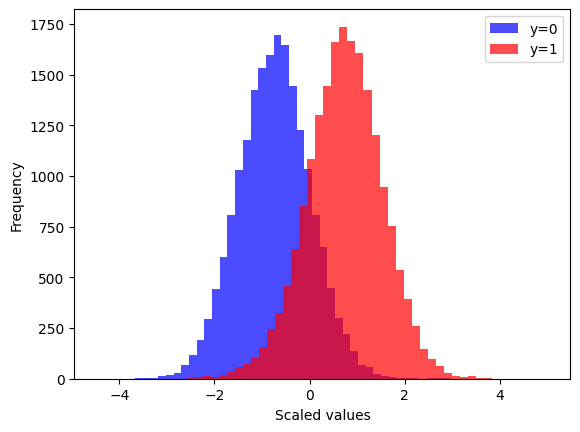

In [4]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X= sc.fit_transform(x[:,:,0])
# X_test = sc.transform(x_test)
pca = PCA(n_components = 1)
X = pca.fit_transform(X)
print (pca.explained_variance_)
print (pca.explained_variance_ratio_)
print (pca.explained_variance_ratio_.cumsum())
# X_test = pca.transform(X_test)
print("X shape: {}".format(X.shape))
x_red =X[y[:] == 1, 0]  # Use y[:, 0] for indexing
x_blue = X[y[:] == 0, 0] 

# Create a histogram with two different colors
plt.hist(x_blue, bins=50, color='blue', alpha=0.7, label='y=0')
plt.hist(x_red, bins=50, color='red', alpha=0.7, label='y=1')
# Add labels and legend
plt.xlabel('Scaled values')
plt.ylabel('Frequency')
plt.legend()

# Show the plot
plt.show()

In [4]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.80, random_state=45)
x1_train,x2_train,x3_train=x_train[:,:,0],x_train[:,:,1],x_train[:,:,2]
x1_test,x2_test,x3_test=x_test[:,:,0],x_test[:,:,1],x_test[:,:,2]
print(x1_train.shape,y_train.shape)

(7709, 2) (7709,)


## Model1

In [5]:
classifier = LogisticRegression(random_state = 42, max_iter=500)
classifier.fit(x1_train, y_train)
print(classifier.score(x1_test,y_test))
pred1 = classifier.predict(x1_test)

0.9787585938513426


In [9]:
count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==0:
        count+=1
        if pred1[i] == 0:
            count1+=1
print(count,count1)
print(count1/count)

count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==1:
        count+=1
        if (pred1[i]) ==1:
            count1+=1
print(count,count1)
print(count1/count)

15372 15262
0.9928441321883945
15464 14919
0.9647568546301086


## Model2

In [6]:
classifier = LogisticRegression(random_state = 42, max_iter=500)
classifier.fit(x2_train, y_train)
print(classifier.score(x2_test,y_test))
pred2 = classifier.predict(x2_test)

0.957809054352056


In [10]:
count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==0:
        count+=1
        if pred2[i] == 0:
            count1+=1
print(count,count1)
print(count1/count)

count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==1:
        count+=1
        if (pred2[i]) ==1:
            count1+=1
print(count,count1)
print(count1/count)

15372 15257
0.9925188654696852
15464 14278
0.923305742369374


## Model3

In [7]:
classifier = LogisticRegression(random_state = 42, max_iter=500)
classifier.fit(x3_train, y_train)
print(classifier.score(x3_test,y_test))
pred3 = classifier.predict(x3_test)

0.937216240757556


In [11]:
count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==0:
        count+=1
        if pred3[i] == 0:
            count1+=1
print(count,count1)
print(count1/count)

count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==1:
        count+=1
        if (pred3[i]) ==1:
            count1+=1
print(count,count1)
print(count1/count)

15372 15247
0.9918683320322664
15464 13653
0.8828892912571132


## Majority Voting

In [8]:
count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==0:
        count+=1
        if (pred1[i] + pred2[i] + pred3[i]) < 2:
            count1+=1
print(count,count1)
print(count1/count)

count=0
count1=0
for i in range(y_test.shape[0]):
    if y_test[i]==1:
        count+=1
        if (pred1[i] + pred2[i] + pred3[i]) >=2:
            count1+=1
print(count,count1)
print(count1/count)

15372 15321
0.9966822794691648
15464 14329
0.9266037247801345
